## Visualizing  Spacy + Georesolver  - By Years

In this case, we have used the [SpaCy en_core_web_lg](https://spacy.io/models/en#en_core_web_lg) for finding the Name Entities of all the books of a particular edition,  and select the ones regarding with places (GPE and LOC entities). Later, once we have the locations entities, we use the [georesolver]() of the  [Edinburgh geoparser](https://programminghistorian.org/en/lessons/geoparsing-text-with-edinburgh#patch-fix) to resolve these locations.
                       
The query for running that we have used is the following: 

`sspark-submit --py-files defoe.zip defoe/run_queries.py nls_gaz.txt  nls -l query_distributed_topics.txt -n 16 `


And the queries/lang_model.yml specifies the spaCy language model to use:
`lang_model: en_core_web_lg`



### Loading the necessary libraries

In [1]:
import yaml
from IPython.core.display import display, HTML
import pandas as pd 
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

### Functions

In [2]:
def read_query_results(filename):
    with open('../../../results_Gazetteer/results_without_bb/'+filename, 'r') as f:
        query_results = yaml.load(f)
    return query_results


In [3]:
def geresolution_dataframe(result):
    dfs=[]
    data=[]
    c_locs=[]    
    for i in result.keys():
        print("year %s" %i)
        t_ind = 0
        e_ind = 0
        year = i
        for k in result[i]:
            locs= k["georesolution_page"]
            page = k["text_unit id"]
            if locs != {}:
                data=[]
                l_ind = 0
                for t in locs:
                    if type(locs[t]) == type([]) :
                        c_locs=locs[t].copy()
                        c_locs.append(t.split("-")[0])
                        c_locs.append(page)
                        c_locs.append(year)
                        data.append(c_locs)
                        l_ind = l_ind + 1   
                e_ind = t_ind + l_ind 
                if data:
                    df_page = pd.DataFrame(data, columns = ['Latitude', 'Longitude', 'Place', 'Page', 'Year'], 
                                      index=list(range(t_ind, e_ind)))
                    dfs.append(df_page)
                    t_ind=e_ind
    df_total = pd.concat(dfs)
    return df_total

In [4]:
def get_place(df, lat, long):
    df_new=df.loc[(df['Latitude'] == lat) & (df['Longitude'] == long)]['Place']
    return df_new.count(), df_new.iloc[0]

In [5]:
def label_freq_places(df_total, df_max_geolocations, filter_list):
    place_label=[]
    place_freq = []
    i_limit = 15
    i =0
    k =0 
    while k < i_limit:
        place_count, place_name = get_place(df_total, df_max_geolocations.iloc[i]['Latitude'], df_max_geolocations.iloc[i]['Longitude'])
        if place_name not in filter_list:
            #print(i, place_count,place_name)
            if place_name not in place_label:
                k = k + 1
            place_label.append(place_name)
            place_freq.append(place_count)
         
        i = i + 1
    return place_label, place_freq

In [43]:
def plot_bar_places_by_years(df_group_places_years,plot_type="resolved"):
    num_subplots=len(df_group_places_years.keys())
    fig, axs = plt.subplots(num_subplots,1, squeeze=False)
    plt.subplots_adjust(hspace = 0.8, top=0.95)
    fig.set_size_inches(25, 45)
    i=0
    if plot_type == "resolved":
        fig.suptitle('15 Places most mentioned using Spacy and the Georesolver', fontsize = 25)
    else:
        fig.suptitle('15 Places most mentioned but not resolved using Spacy and the Georesolver ', fontsize = 25)
    for y in sorted(df_group_places_years.keys()):
        df_group_places = df_group_places_years[y]
        index = np.arange(len(df_group_places['Place']))

        if plot_type == "resolved":
            axs[i,0].bar(index, df_group_places['count'], color='green')
            axs[i,0].set_title('Year %s' %y, fontsize=25)
        else: 
            axs[i,0].bar(index, df_group_places['count'], color='darkgreen')
            axs[i,0].set_title('Year %s' %y, fontsize=25)
        axs[i,0].set_xticks(index) 
        axs[i,0].set_xticklabels(list(df_group_places['Place']), rotation=25, fontsize=22)
        fig.canvas.draw()
        axs[i,0].set_yticklabels(axs[i,0].get_yticklabels(), fontsize=25)  
        axs[i,0].set_ylabel('Frequency', fontsize=25) 
        i=i + 1

In [39]:
# Plot lines of different places
def cumulative_plot(df, list_places, list_years):
    fig = plt.figure(figsize=(12, 6))
    line_weight = 3
    alpha = .5
    tt=df_group_places_years_final.reset_index()
    years=set()
    for pl in list_places:
        freq_term={}
        for i in sorted(list_years):
            try:
                freq_term[i]= list(tt.loc[(tt['Place']==pl) & (tt['level_0']==i) ]["count"])[0]
            except:
                freq_term[i] = 0
        plt.plot(*zip(*sorted(freq_term.items())), lw=line_weight, alpha=alpha, label=pl, marker='d') 
    
    for i in sorted(list_years):
        years.add(i)
    plt.xticks(sorted(list(years)), rotation=50, fontsize=20)
    plt.tick_params(axis='both', which='minor', labelsize=20)
    plt.title('Yearly cumulative frequencies using\n'+ 'Spacy and the Georesolver',  fontsize=25)
    plt.legend(loc='upper left')
    plt.ylabel('Frequency of Places', fontsize=20) 
    plt.xlabel("Years", fontsize=20) 
    plt.show()

### Information about the defoe geoparser query

This query does the following tasks:

- Ingests all the pages from each directory listed in nls_gaz.txt, which each corresponds to a book of the "Scottish Gazzeters"
- Cleans the text applied two fixes: Long-s and hyphen words
- Identifies *entities* using the original SpaCy en_core_web_lg model.
- From the previous entities, just selects the one about *location* and creates an xml (in memory) per page with these "location" entities. 
- Applies the georesolve of the Edinburgh geoparser to each xml and gets lat and long. **Important: Everything is in memory, we do not create XML files in those steps**
- Group the results by year, and also gets some informative metadata


As a result we get a file per book with an entry per page with the following information:

    * edition: Edition of the gazetteer
    * georesolution_page: Page's geolocations after applying the georesolver
    * page_filename: Page's filename (page's relative path)
    * text_unit id: The number of this page (e.g. Page 1)
    * lang_model : The language model applied (en_core_web_lg)
    * year: Publication year 

`Example:
     
    - edition: '1828'
      georesolution_page:
       Aberdeen-rb19:
        - '57.1333333'
        - '-2.1'
       Edinburgh-rb7:
        - '55.9497284685701'
        - '-3.19333076477051'
    
      lang_model: en_core_web_lg
      page_filename: alto/97351031.34.xml
      text_unit id: Page27
      title: Descriptive account of the principal towns in Scotland to accompany Wood's town atlas`


### Reading the file and creating the first dataframe

In [8]:
results=read_query_results('georesolution_en_core_web_lg_total')

In [9]:
df_total= geresolution_dataframe(results)

year 1838
year 1882
year 1901
year 1825
year 1868
year 1803
year 1806
year 1828
year 1846
year 1848
year 1883
year 1842


In [10]:
df_total.head(15)

,Latitude,Longitude,Place,Page,Year
0,40.2593,-75.0868,WARWICK SQUARE,Page9,1838
1,51.5879,-0.1063,LONDON,Page9,1838
2,38.8873341,-77.05553279999999,SCOTLAND,Page9,1838
3,55.95,-3.2,EDINBURGH,Page9,1838
4,55.95,-3.3725,EDINBURGH,Page9,1838
5,55.8666667,-4.25,GLASGOW,Page9,1838
6,36.933119,-94.0946568,Berwick,Page11,1838
7,55.36667,-2.36667,the Cheviot Hills,Page11,1838
8,54,-4,Great Britain,Page11,1838
9,,,the Solway Firth,Page11,1838


### Generic Explorations 

**Important: Number of Places that has been identified!**

In [11]:
df_total[["Place"]].count()

Place    320629
dtype: int64

### Explorations with georesolved places

**Important: Going to remove City of | Contry of | County of  in the strings of Places**

In [12]:
df_total['Place'] = df_total['Place'].str.replace(r'City of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'city of ', '')

In [13]:
df_total['Place'] = df_total['Place'].str.replace(r'Country of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'country of ', '')

In [14]:
df_total['Place'] = df_total['Place'].str.replace(r'County of ', '')
df_total['Place'] = df_total['Place'].str.replace(r'county of ', '')

In [15]:
df_total['Place'] = df_total['Place'].str.replace(r'the ', '')
df_total['Place'] = df_total['Place'].str.replace(r'The ', '')

**Important: Number of Places that has been identified but not resolved!**

In [16]:
df_total.loc[df_total['Latitude'] == ''].count()

Latitude     36650
Longitude    36650
Place        36650
Page         36650
Year         36650
dtype: int64

**Important: Number of Places that has been identified AND  resolved!**

In [17]:
df_total.loc[df_total['Latitude'] != ''].count()

Latitude     283979
Longitude    283979
Place        283979
Page         283979
Year         283979
dtype: int64

**Important: New dataframe- df_resolved- without the rows has been resolved!!**

In [18]:
df_resolved = df_total[df_total['Latitude'] != '']

In [19]:
df_resolved.count()

Latitude     283979
Longitude    283979
Place        283979
Page         283979
Year         283979
dtype: int64

**Places names - forcing all to lower case, and later capitalize them**

In [20]:
df2 = df_resolved.copy()
df2['Place']=df_resolved['Place'].apply(str.lower)

In [21]:
df_capitalized= df2.copy()
df_capitalized['Place']=df2['Place'].apply(str.capitalize)
#displaying the first 15 rows
df_capitalized.head(15)

,Latitude,Longitude,Place,Page,Year
0,40.2593,-75.0868,Warwick square,Page9,1838
1,51.5879,-0.1063,London,Page9,1838
2,38.8873341,-77.05553279999999,Scotland,Page9,1838
3,55.95,-3.2,Edinburgh,Page9,1838
4,55.95,-3.3725,Edinburgh,Page9,1838
5,55.8666667,-4.25,Glasgow,Page9,1838
6,36.933119,-94.0946568,Berwick,Page11,1838
7,55.36667,-2.36667,Cheviot hills,Page11,1838
8,54,-4,Great britain,Page11,1838
10,40.9477778,-72.42277780000001,North sea,Page11,1838


**Important: Calculating the number of georesolved places by year**

Here is when I realised that we had empty geolocations for some editions. 

In [22]:
df_capitalized.groupby("Year")["Place"].count()

Year
1803     6638
1806     6561
1825     4380
1828     1223
1838    14383
1842    30196
1846    29334
1848    15035
1868    47170
1882    22593
1883    46454
1901    60012
Name: Place, dtype: int64

### Visualizing the 15 places more mentioned (and resolved) per year

In [23]:
mpl.rcParams['figure.dpi']=300
years_list = df_capitalized['Year'].unique()
filter_list=[]
df_group_places_years={}
for y in years_list:
    df_filter_year=df_capitalized.loc[df_capitalized['Year'] == y]
    df_max_geolocations = df_filter_year[['Latitude','Longitude', 'Place']].groupby(['Place'])['Place'] \
                             .count() \
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)
    filter_list=['Ii', 'United presbyterian']
    #place_label, place_freq = label_freq_places(df_filter_year, df_max_geolocations, filter_list)
    
    df_max_filter= df_max_geolocations[~df_max_geolocations['Place'].isin(filter_list)]
    place_label= df_max_filter['Place'].tolist()[0:15]
    place_freq= df_max_filter['count'].tolist()[0:15]
    df_places = {'Place':place_label,'Place_freq':place_freq}
    df_places_freq = pd.DataFrame(df_places)
    df_group_places = df_places_freq.groupby(['Place'])['Place_freq'].sum()\
                             .reset_index(name='count') \
                             .sort_values(['count'], ascending=False)   
    df_group_places_years[y]=df_group_places

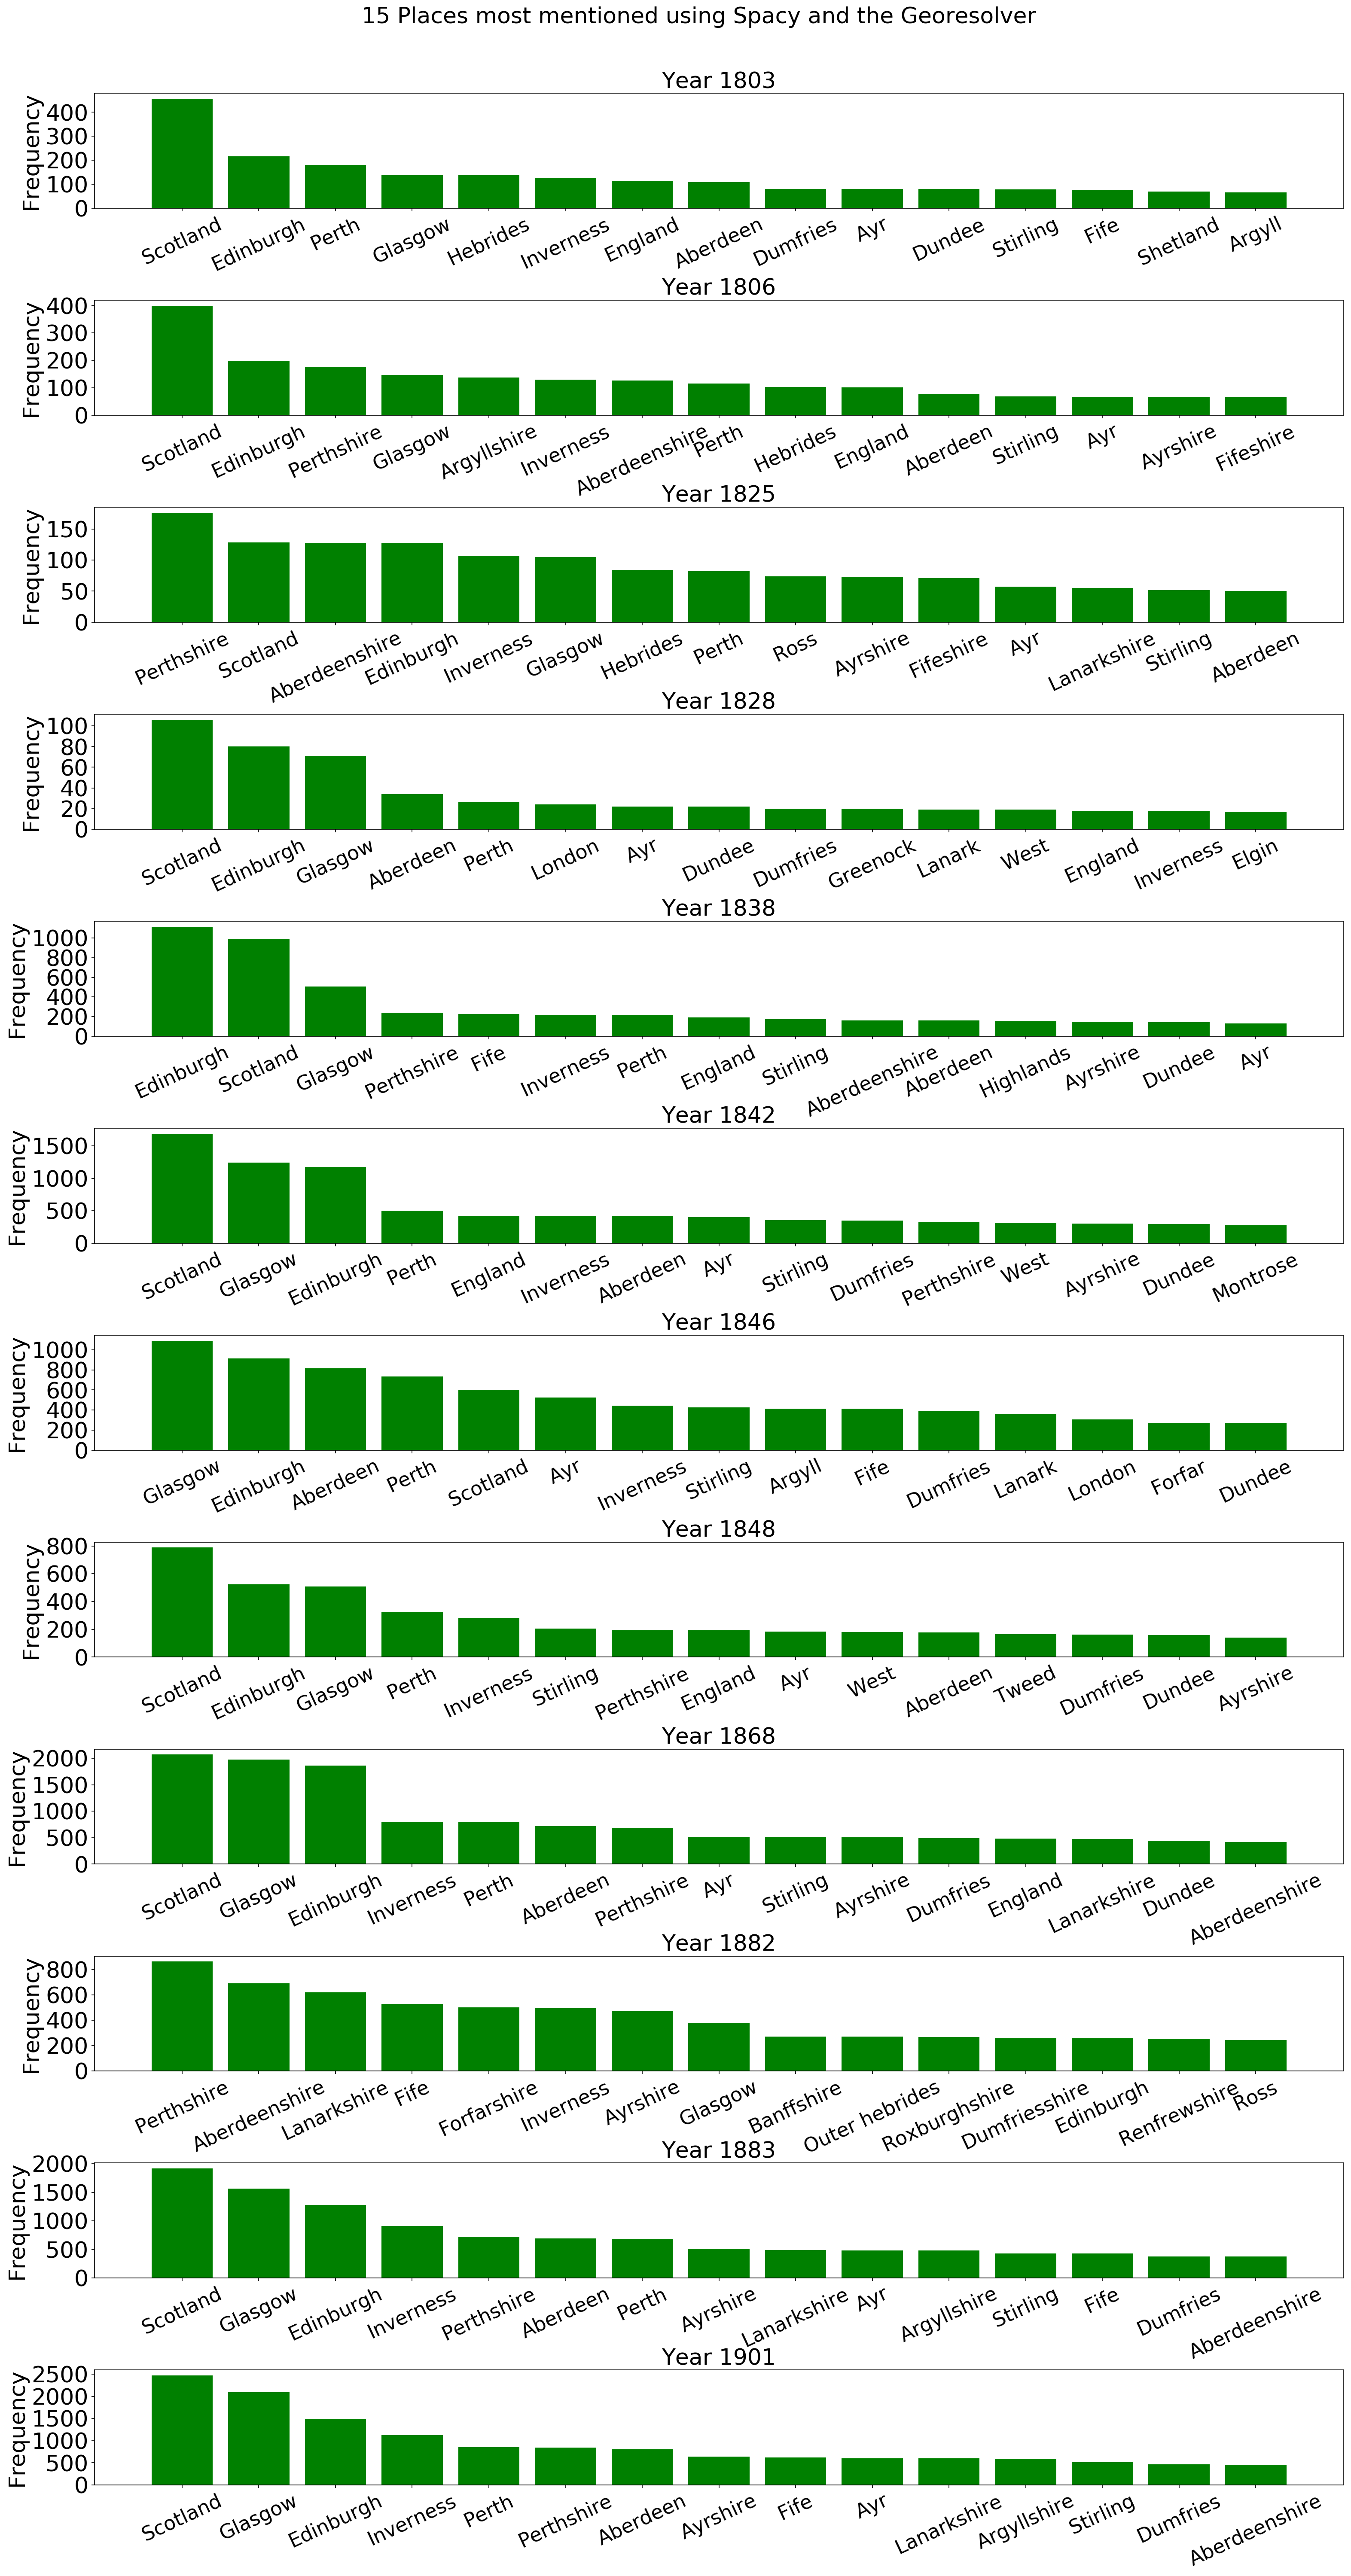

In [44]:
plot_bar_places_by_years(df_group_places_years,plot_type="resolved")

In [25]:
# Exploring the 15 places more georeolved for a particular year - e.g1828. 
df_group_places_years["1828"]

,Place,count
13,Scotland,106
4,Edinburgh,80
7,Glasgow,71
0,Aberdeen,34
12,Perth,26
11,London,24
1,Ayr,22
3,Dundee,22
2,Dumfries,20
8,Greenock,20


### Cumulative Yearly Plot 

First we have to create a new concatenated dataframe with all the information per year - Years as the index 

In [26]:
df_group_places_years_final = pd.concat(df_group_places_years)

In [27]:
df_group_places_years_final.head(15)

Place  count
1803 12   Scotland    456
     5   Edinburgh    217
     11      Perth    181
     8     Glasgow    137
     9    Hebrides    137
     10  Inverness    127
     6     England    114
     0    Aberdeen    109
     3    Dumfries     81
     2         Ayr     80
     4      Dundee     80
     14   Stirling     78
     7        Fife     77
     13   Shetland     70
     1      Argyll     67

Just an example how to explore the number of times that Edinburgh has been georesolved over the years

In [28]:
df_group_places_years_final.loc[df_group_places_years_final['Place']=='Edinburgh']


,,Place,count
1803,5,Edinburgh,217
1806,5,Edinburgh,198
1825,4,Edinburgh,127
1828,4,Edinburgh,80
1838,5,Edinburgh,1115
1842,5,Edinburgh,1180
1846,5,Edinburgh,915
1848,5,Edinburgh,524
1868,6,Edinburgh,1864
1882,4,Edinburgh,257


In [29]:
df_group_places_years_final.Place.unique()

array(['Scotland', 'Edinburgh', 'Perth', 'Glasgow', 'Hebrides',
       'Inverness', 'England', 'Aberdeen', 'Dumfries', 'Ayr', 'Dundee',
       'Stirling', 'Fife', 'Shetland', 'Argyll', 'Perthshire',
       'Argyllshire', 'Aberdeenshire', 'Ayrshire', 'Fifeshire', 'Ross',
       'Lanarkshire', 'London', 'Greenock', 'Lanark', 'West', 'Elgin',
       'Highlands', 'Montrose', 'Forfar', 'Tweed', 'Forfarshire',
       'Banffshire', 'Outer hebrides', 'Roxburghshire', 'Dumfriesshire',
       'Renfrewshire'], dtype=object)

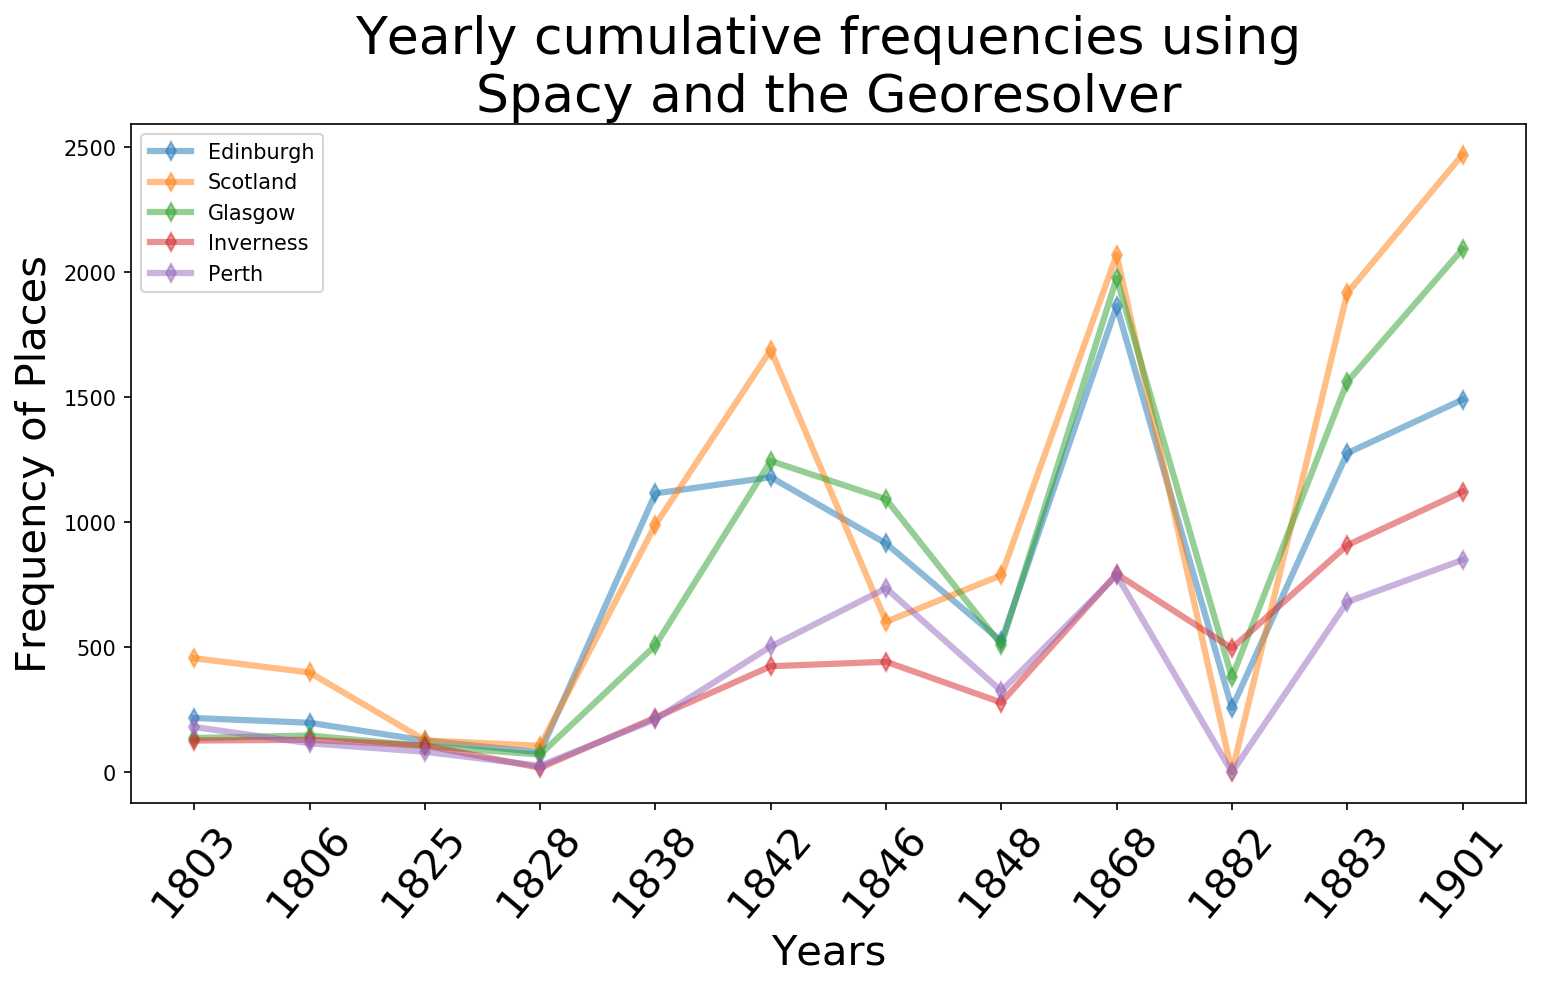

In [40]:
#df_group_places_years_final.loc[df_group_places_years_final['Place']=='Edinburgh']
mpl.rcParams['figure.dpi']=150
list_places=["Edinburgh", "Scotland", "Glasgow", "Inverness", "Perth"]
cumulative_plot(df_group_places_years, list_places, sorted(years_list))